# LSND Constraints on Vector Mediator

In this notebook, we will investigate the constraints on the Hazma vector-mediator model from the Liquid Scintillator Neutrino Detector (LSND) which ran from 1993 to 1998. This experiment impinged a high luminosity proton beam on a fixed target, resulting in a large number of pions ($\sim10^{21}$ throughout the duration of the experiment.) A large tank of mineral oil (50,000 gallons) with about 14kg of b-PDB (2-(4-tert-butylphenyl)-5-(4-biphenyl)-1,3,4-oxadiazole) was placed roughly 30 meters away from the fixed target. This tank housed 1220 photomultiplier tubes in order to detect Cherenkov light emitted by neutrino interactions with the mineral oil.

However, if there exists a dark $\mathrm{U}(1)_{\mathrm{dark}}$ vector boson, $V$, which kinetically mixes with the SM photon, the we expect the neutral pions to have a non-zero branching ratio through $\pi^{0}\to V\gamma$. If $V$ has a macroscopic decay length, it would then have been possible for LSND to detect vector decays into leptons: $V\to e^{+}e^{-}$. Alternatively, if $V$ interacts with DM and $\mathrm{Br}(V\to2m_{\chi})\neq0$, then it would be possible for the DM to up-scatter an electron in the tank, resulting in a high-energy electron, detectable via Cherenkov radiation.

Following arXiv:0906.5614v2, we first reproduce their results. We then apply the same formalism to place constraints on the Hazma vector mediator model.

## Setup

### Imports

In [15]:
from hazma.parameters import electron_mass as me
from hazma.parameters import muon_mass as mmu
from hazma.parameters import neutral_pion_mass as mpi0
from hazma.parameters import alpha_em
from hazma.vector_mediator import KineticMixing
from hazma.relic_density import relic_density

from hazma.gamma_ray_parameters import egret_diffuse
from hazma.gamma_ray_parameters import comptel_diffuse
from hazma.gamma_ray_parameters import fermi_diffuse

from hazma.gamma_ray_parameters import gc_target, gc_bg_model
from hazma.gamma_ray_parameters import A_eff_e_astrogam
from hazma.gamma_ray_parameters import energy_res_e_astrogam
from hazma.gamma_ray_parameters import T_obs_e_astrogam

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from matplotlib.colors import LogNorm

### LSND Parameters

In [30]:
# 1 cm = 5.06773e10 MeV^-1
cm_to_inv_mev = 5.06773e10
# conversion factor from m -> 1/MeV
meter_to_inv_mev = cm_to_inv_mev * 1e2
# conversion factor from cm^2 -> 1/MeV^2
cm2_to_inv_mev = 2.56819e21


lsnd_parameters = {
    "neutrino_flux": 1.3e14, # nu / cm^2
    "detector_area": 2.5e5, # cm^2
    "detector_dist": 30.0e2, # cm
    "detector_len": 8.75e2, # cm
    "detector_vol": 2.5e5 * 8.75e2, # (area) * (length), cm^3
    "detector_ang_size": 4e-2, # dΩ/4π
    "proton_beam_eng": 800.0, # MeV
    "number_pions": 1.3e14 * 2.5e5 / 4e-2 # (Φν)x(Adet)/(dΩ/4π)
}

br_delta_neutron_photon = 0.005
mass_delta = 1232.0 # MeV
mass_neutron = 939.56 # MeV

In [31]:
lsnd_parameters['number_pions']

8.125e+20

### DM Velocity Distribution

In [17]:
class VelocityDistribution(object):
    def __init__(self):
        self.v0 = 220. / 299792.458
        self.vesc = 544. / 299792.458
        
    def __call__(self, v):
        if v > self.vesc:
            return 0.0
    
        term1 = (self.v0*np.sqrt(np.pi))**3 * np.math.erf(self.vesc/self.v0)
        term2 = -2.0 * self.v0**3 * np.pi * (self.vesc/self.v0) * np.exp(-self.vesc**2/self.v0**2)
    
        return np.exp(-v**2 / self.v0**2) / (term1 + term2)    

    
velocity_dist = VelocityDistribution()

In [18]:
4*np.pi * quad(lambda v: v**2 * velocity_dist(v), 0.0, velocity_dist.vesc)[0]

1.0

### Computing $\langle\sigma v\rangle$

In [19]:
def computeSigmaV(model):
    def integrand(v):
        ecm = 2.0 * model.mx * (1.0 + 0.5 * v**2)
        return model.annihilation_cross_sections(ecm)['total'] * v**2 * velocity_dist(v)
    
    return 4 * np.pi * quad(integrand, 0.0, velocity_dist.vesc)[0]

## Reproducing arXiv:0906.5614v2

### $m_{V} < 2 m_{\chi}$ (or $g_{V\chi} = 0$)

In [20]:
class MockModel(object):
    def __init__(self):
        pass
            
    def _vector_width(self, mv, eps):
        """
        Returns width of the vector-mediator in MeV.
        
        Parameters
        ----------
        mv: float
            Mass of vector mediator in MeV
        ϵ: float
            Kinetic mixing parameter
        """
        width = 0.0
        pf = alpha_em / 3.0 * eps**2 * mv
        # sum over electron and muon contributions
        for mu in [me/mv, mmu/mv]:
            if mu < 0.5:
                width += pf * np.sqrt(1.0-4.0*mu**2) * (1.0 + 2.0*mu**2)
        return width
    
    
    def _prob_decay(self, mv, eps):
        """
        Returns probability of the vector decaying 
        within the LSND detector.
        
        Parameters
        ----------
        mv: float
            Mass of vector mediator in MeV
        eps: float
            Kinetic mixing parameter
        """
        width = self._vector_width(mv, eps)
        # assume vector takes 1/2 of energy from π->Vγ
        eng_v = lsnd_parameters['proton_beam_eng'] / 2.0
        
        if mv < eng_v and width > 0.0:
            gamma = eng_v / mv
            momentum = np.sqrt(eng_v**2 - mv**2)
            velocity = momentum / eng_v
            lifetime = 1.0 / width
            decay_length = gamma * velocity * lifetime / cm_to_inv_mev
            L = lsnd_parameters['detector_dist']
            dL = lsnd_parameters['detector_len'] / 2.0
            return (np.exp(-(L-dL)/decay_length) - np.exp(-(L+dL)/decay_length))
        else:
            return 0.0
        
    def _prob_detect(self, mv, eps):
        """
        Computes the probability of detecting a vector mediator
        decaying inside the LSND detector.
        
        Parameters
        ----------
        mv: float
            Mass of vector mediator in MeV
        eps: float
            Kinetic mixing parameter
        """
        return lsnd_parameters['detector_ang_size'] / (4.0 * np.pi) * self._prob_decay(mv,eps)
    
    def _number_vectors(self, mv, eps):
        """
        Computes the number of vectors produced during LSND 
        experiment.
        
        Parameters
        ----------
        mv: float
            Mass of vector mediator in MeV
        eps: float
            Kinetic mixing parameter
        """
        num_vec = 0
        # π -> V + γ
        if mv < mpi0:
            mu = mv / mpi0
            num_vec += lsnd_parameters['number_pions'] * 2.0 * eps**2 * (1.0 - mu**2)**3
        # Δ -> N + V
        if mv < mass_delta - mass_neutron:
            mu = mv / (mass_delta - mass_neutron)
            num_vec += (lsnd_parameters['number_pions'] * br_delta_neutron_photon * 
                        eps**2 * (1.0 - mu**2)**1.5)
        return num_vec
    
    def _number_events(self, mv, eps):
        """
        Computes the number of events expected to be
        seen at LSND.
        
        Parameters
        ----------
        mv: float
            Mass of vector mediator in MeV
        k: float
            Kinetic mixing parameter
        """
        return self._number_vectors(mv,eps) * self._prob_detect(mv,eps)
    
    def number_events(self, mv, eps):
        if hasattr(mv, '__len__') or hasattr(eps, '__len__'):
            return np.vectorize(self._number_events)(mv,eps)
        return self._number_events(mv, eps)

In [21]:
model = MockModel()

mvs = np.logspace(0,3,100)
ks = np.logspace(-9,-3,100)
MVS,KS = np.meshgrid(mvs, ks)

NS = model.number_events(MVS,KS)

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Log scale: values of z <= 0 have been masked
  


Text(0.5, 1.0, 'Number of detections from $V\\to e^{+}e^{-}$')

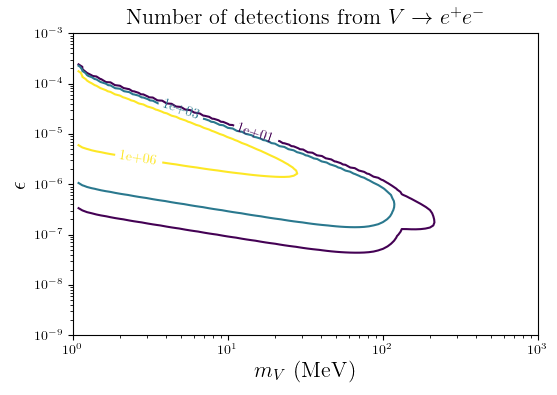

In [23]:
plt.figure(dpi=100)
CS = plt.contour(MVS,KS,NS,levels=[1e1, 1e3,1e6], norm=LogNorm())
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\epsilon$', fontsize=16)
plt.xlabel(r'$m_V \ (\mathrm{MeV})$', fontsize=16);

plt.clabel(CS, CS.levels, inline=True, fmt=r'%.0e',fontsize=10)
plt.title(r"Number of detections from $V\to e^{+}e^{-}$", fontsize=16)

### $2m_{\chi} < m_{V}$ (and $g_{V\chi} \neq 0$)

In [27]:
class MockModel2(object):
    def __init__(self):
        pass

    def _vector_width(self, mx, mv, gvxx, eps):
        """
        Returns unvectorized width of the vector-mediator in MeV.

        Parameters
        ----------
        mx: float
            Dark matter mass in MeV
        mv: float
            Mass of vector mediator in MeV
        gvxx: float
            Coupling of DM to vector mediator
        eps: float
            Kinetic mixing parameter
        """
        width = 0.0
        pfl = alpha_em / 3.0 * eps**2 * mv
        pfd = (gvxx**2 / (4.0 * np.pi)) / 3.0 * mv
        # sum over electron, muon and DM contributions
        for pf, mu in [(pfl, me/mv), (pfl, mmu/mv), (pfd, mx/mv)]:
            if mu < 0.5:
                width += pf * np.sqrt(1.0-4.0*mu**2) * (1.0 + 2.0*mu**2)
        return width

    
    def _br_v_xx(self, mx, mv, gvxx, eps):
        """
        Returns unvectorized width of the vector-mediator in MeV.

        Parameters
        ----------
        mx: float
            Dark matter mass in MeV
        mv: float
            Mass of vector mediator in MeV
        gvxx: float
            Coupling of DM to vector mediator
        eps: float
            Kinetic mixing parameter
        """
        width=0.0
        mu = mx / mv
        if mu < 0.5:
            width = self._vector_width(mx, mv, gvxx, eps)
            alphad = gvxx**2 / (4.0 * np.pi)
            return alphad / 3.0 * mv * np.sqrt(1.0-4.0*mu**2) * (1.0 + 2.0*mu**2) / width
        return 0.0

    
    def _number_vectors(self, mx, mv, gvxx, eps):
        """
        Computes the number of vectors produced during LSND 
        experiment.

        Parameters
        ----------
        mx: float
            Dark matter mass in MeV
        mv: float
            Mass of vector mediator in MeV
        gvxx: float
            Coupling of DM to vector mediator
        eps: float
            Kinetic mixing parameter
        """
        num_vec = 0
        # π -> V + γ
        if mv < mpi0:
            mu = mv / mpi0
            num_vec += lsnd_parameters['number_pions'] * 2.0 * eps**2 * (1.0 - mu**2)**3
        # Δ -> N + V
        if mv < mass_delta - mass_neutron:
            mu = mv / (mass_delta - mass_neutron)
            num_vec += (lsnd_parameters['number_pions'] * br_delta_neutron_photon *
                        eps**2 * (1.0 - mu**2)**1.5)
        return num_vec

    
    def _sigma_ex_ex(self, mx, mv, gvxx, eps):
        Ex = lsnd_parameters['proton_beam_eng'] / 4.0
        Efmin = 20.0
        alphad = gvxx**2 / (4.0 * np.pi)
        return ((2*np.pi*alphad*alpha_em*eps**2*(
            (2*Ex*me + mv**2)/(2*Efmin*me + mv**2) -
            ((2*Ex*me + mv**2)*(2*Ex*me + me**2 + mx**2)) /
            (4*Ex**2*me**2 + 2*me**4 + 2*Ex*me*(2*me**2 + mv**2) +
             mv**2*mx**2 + me**2*(mv**2 - 2*mx**2)) +
            np.log(2*Efmin*me + mv**2) -
            np.log(mv**2 + (2*me**2*(2*Ex**2 + 2*Ex*me + me**2 - mx**2)) /
                   (2*Ex*me + me**2 + mx**2))))/(Ex*me))

    
    def _number_dm_scatters(self, mx, mv, gvxx, eps):
        if mv > 2.0 * mx:
            sig = self._sigma_ex_ex( mx, mv, gvxx, eps) * 3.89379e-22
            dm_flux = 2.0 * self._number_vectors(mx, mv, gvxx, eps) * self._br_v_xx( mx, mv, gvxx, eps)
            dm_flux *= lsnd_parameters['detector_ang_size'] / lsnd_parameters['detector_area']
            return 2.66386e23 * lsnd_parameters['detector_vol'] * sig * dm_flux
        else:
            return 0.0

        
    def number_dm_scatters(self, mx, mv, gvxx, eps):
        if hasattr(mv, '__len__') or hasattr(k, '__len__'):
            return np.vectorize(self._number_dm_scatters)(mx, mv, gvxx, eps)
        return self._number_dm_scatters(mx, mv, gvxx, eps)

In [28]:
model = MockModel2()

mx = 1.0

mvs = np.logspace(0,3,200)
epss = np.logspace(-6,-2,200)
MVS,EPSS = np.meshgrid(mvs, epss)
ALPHADS = 1e-6*alpha_em/EPSS**2*(MVS/10)**4 * (1.0/mx)**2
GVXXS = np.sqrt(4.0 * np.pi * ALPHADS)

NS = model.number_dm_scatters(mx, MVS, GVXXS, EPSS)

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Log scale: values of z <= 0 have been masked
  


<a list of 4 text.Text objects>

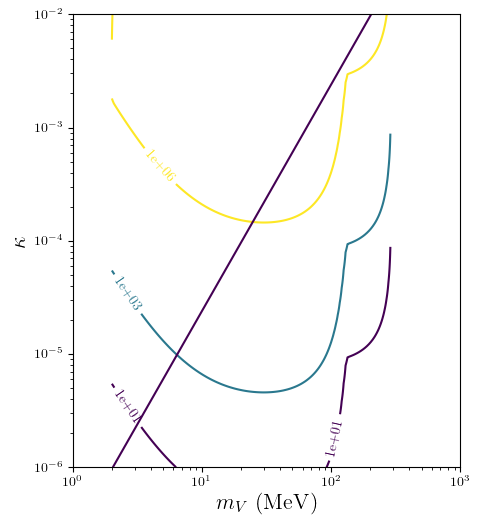

In [29]:
plt.figure(dpi=100,figsize=(5,6))
CS = plt.contour(MVS,EPSS,NS,levels=[1e1,1e3,1e6], norm=LogNorm())
plt.contour(MVS,EPSS,ALPHADS,levels=[4.0*np.pi])
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\kappa$', fontsize=16)
plt.xlabel(r'$m_V \ (\mathrm{MeV})$', fontsize=16);

plt.clabel(CS, CS.levels, inline=True, fmt=r'%.0e',fontsize=10,)

## Hazma

### $m_{V} < 2m_{\chi}$ (or $g_{V\chi} = 0$)

In [45]:
class VectorMediatorContraint(KineticMixing):
    def __init__(self, mx,mv,gvxx,eps):
        super(VectorMediatorContraint, self).__init__(mx,mv,gvxx,eps)         
            
    def _prob_decay(self):
        """
        Returns unvectorized probability of the vector decaying 
        within the LSND detector.
        """
        ev = lsnd_parameters['proton_beam_eng'] / 2.0
        width = self.width_v
        if self.mv < ev and width > 0.0:
            gamma = ev / self.mv
            momentum = np.sqrt(ev**2 - self.mv**2)
            velocity = momentum / ev
            lifetime = 1.0 / width
            decay_length = gamma * velocity * lifetime / cm_to_inv_mev
            L = lsnd_parameters['detector_dist']
            dL = lsnd_parameters['detector_len'] / 2.0
            return (np.exp(-(L-dL)/decay_length) - np.exp(-(L+dL)/decay_length))
        else:
            return 0.0
        
    def _prob_detect(self):
        """
        Computes the probability of detecting a vector mediator
        decaying inside the LSND detector.
        """
        return lsnd_parameters['detector_ang_size'] / (4.0 * np.pi) * self._prob_decay()
    
    def _number_vectors(self):
        """
        Computes the number of vectors produced during LSND 
        experiment.
        """
        num_vec = 0
        # π -> V + γ
        if self.mv < mpi0:
            mu = self.mv / mpi0
            # br(π->Vγ)
            br = (2*self.eps**2*(-1 + mu**2)**3)/(-1 + 2*self.eps**2*(-1 + mu**2)**3)
            num_vec += lsnd_parameters['number_pions'] * br
        # Δ -> N + V
        if self.mv < mass_delta - mass_neutron:
            mu = self.mv / (mass_delta - mass_neutron)
            num_vec += (lsnd_parameters['number_pions'] * br_delta_neutron_photon * 
                        self.eps**2 * (1.0 - mu**2)**1.5)
        return num_vec
    
    def _number_events(self, mx, mv, gvxx, eps):
        """
        Computes the number of events expected to be
        seen at LSND.
        
        Parameters
        ----------
        self.mv: float
            Mass of vector mediator in MeV
        self.eps: float
            Kinetic mixing parameter
        """
        self.mx = mx
        self.mv = mv
        self.gvxx = gvxx
        self.eps = eps
        return self._number_vectors() * self._prob_detect()
    
    def number_events(self, mx, mv, gvxx, eps):
        if (hasattr(self.mx, '__len__') or 
            hasattr(self.mv, '__len__') or 
            hasattr(gvxx, '__len__') or 
            hasattr(eps, '__len__')):
            return np.vectorize(self._number_events)(mx, mv, gvxx, eps)
        return self._number_events(mx, mv, gvxx, eps)

In [53]:
model = VectorMediatorContraint(200.0, 50.0, 0.0, 1e-3)

mvs = np.logspace(0,3,100)
epss = np.logspace(-9,-3,100)
MVS,EPSS = np.meshgrid(mvs, epss)

NS = model.number_events(model.mx, MVS, model.gvxx, EPSS)

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Log scale: values of z <= 0 have been masked
  


<a list of 3 text.Text objects>

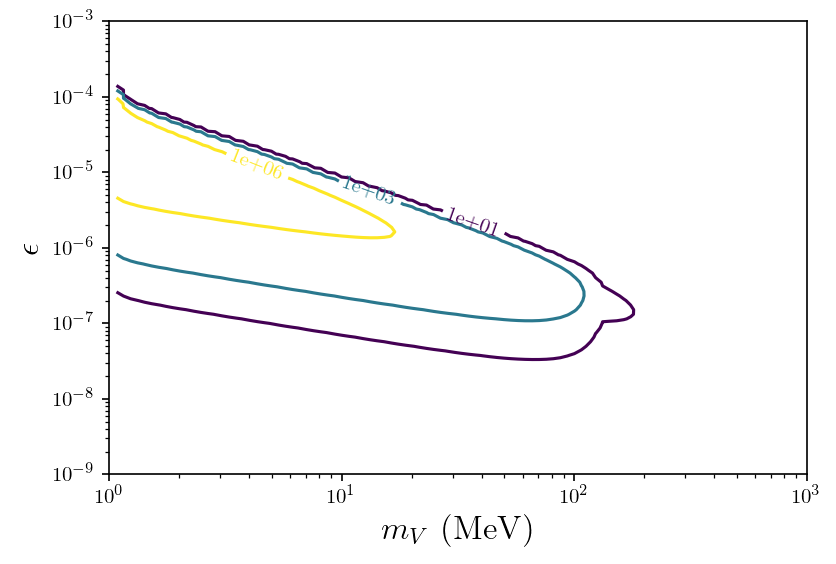

In [54]:
plt.figure(dpi=150)
CS = plt.contour(MVS,EPSS,NS,levels=[1e1, 1e3,1e6], norm=LogNorm())
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\epsilon$', fontsize=16)
plt.xlabel(r'$m_V \ (\mathrm{MeV})$', fontsize=16);

plt.clabel(CS, CS.levels, inline=True, fmt=r'%.0e',fontsize=10)

### $m_{V} > 2m_{\chi}$ (and $g_{V\chi} \neq 0$)

In [59]:
class VectorMediatorContraint2(KineticMixing):
    def __init__(self, mx,mv,gvxx,eps):
        super(VectorMediatorContraint2, self).__init__(mx,mv,gvxx,eps)
        self._alphad = gvxx**2 / (4.0 * np.pi)
    
    @property
    def alphad(self):
        return self._alphad
    
    @alphad.setter
    def alphad(self, val):
        self._alphad = val
        self.gvxx = np.sqrt(4.0 * np.pi * val)


    def _number_vectors(self):
        """
        Computes the number of vectors produced during LSND 
        experiment.
        """
        num_vec = 0
        # π -> V + γ
        if self.mv < mpi0:
            mu = self.mv / mpi0
            br = (2*self.eps**2*(-1 + mu**2)**3)/(-1 + 2*self.eps**2*(-1 + mu**2)**3)
            num_vec += lsnd_parameters['number_pions'] * br
        # Δ -> N + V
        if self.mv < mass_delta - mass_neutron:
            mu = self.mv / (mass_delta - mass_neutron)
            num_vec += (lsnd_parameters['number_pions'] * br_delta_neutron_photon * 
                        self.eps**2 * (1.0 - mu**2)**1.5)
        return num_vec

    def _sigma_ex_ex(self):
        Ex = lsnd_parameters['proton_beam_eng'] / 4.0
        Efmin = 20.0
        return ((2*np.pi*self.alphad*alpha_em*self.eps**2*(
            (2*Ex*me + self.mv**2)/(2*Efmin*me + self.mv**2) -
            ((2*Ex*me + self.mv**2)*(2*Ex*me + me**2 + self.mx**2)) /
            (4*Ex**2*me**2 + 2*me**4 + 2*Ex*me*(2*me**2 + self.mv**2) +
             self.mv**2*self.mx**2 + me**2*(self.mv**2 - 2*self.mx**2)) +
            np.log(2*Efmin*me + self.mv**2) -
            np.log(self.mv**2 + (2*me**2*(2*Ex**2 + 2*Ex*me + me**2 - self.mx**2)) /
                   (2*Ex*me + me**2 + self.mx**2))))/(Ex*me))

    def _number_dm_scatters(self, mx, mv, alphad, eps):
        self.mx = self.mx if mx == None else mx
        self.mv = self.mv if mv == None else mv
        self.alphad = self.alphad if alphad == None else alphad
        self.eps = self.eps if eps == None else eps
        
        br_v_xx = self.partial_widths()['x x']
        
        if br_v_xx > 0.0:
            sig = self._sigma_ex_ex() * 3.89379e-22
            dm_flux = 2.0 * self._number_vectors() * br_v_xx
            dm_flux *= 4e-2 / lsnd_parameters['detector_area']
            return 2.66386e23 * lsnd_parameters['detector_vol'] * sig * dm_flux
        else:
            return 0.0

    def number_dm_scatters(self, mx=None, mv=None, alphad=None, eps=None):
        if (hasattr(self.mx, '__len__') or 
            hasattr(self.mv, '__len__') or 
            hasattr(alphad, '__len__') or 
            hasattr(eps, '__len__')):
            return np.vectorize(self._number_dm_scatters)(mx, mv, alphad, eps)
        return self._number_dm_scatters(mx, mv, alphad, eps)

In [167]:
mx = 100.0
mvs = np.logspace(0,3,100)
epss = np.logspace(-6,-2,100)

models = np.array([[
    VectorMediatorContraint2(mx, mv, 0.1, eps) for mv in mvs] for eps in epss])

In [88]:
numDMScatters = np.array([[model.number_dm_scatters() for model in models[i]] 
                          for i in range(len(models))])

### All constraints

In [ ]:
class VectorMediatorContraintTot(KineticMixing):
    def __init__(self, mx,mv,gvxx,eps):
        super(VectorMediatorContraint2, self).__init__(mx,mv,gvxx,eps)
        self._alphad = gvxx**2 / (4.0 * np.pi)
    
    @property
    def alphad(self):
        return self._alphad
    
    @alphad.setter
    def alphad(self, val):
        self._alphad = val
        self.gvxx = np.sqrt(4.0 * np.pi * val)
        
    def _prob_decay(self):
        """
        Returns unvectorized probability of the vector decaying 
        within the LSND detector.
        """
        ev = lsnd_parameters['proton_beam_eng'] / 2.0
        widths = self.partial_widths()
        # visible width
        width = widths['e e'] + widths['mu mu'] + widths['pi0 g'] + widths['pi pi']
        if self.mv < ev and width > 0.0:
            gamma = ev / self.mv
            momentum = np.sqrt(ev**2 - self.mv**2)
            velocity = momentum / ev
            lifetime = 1.0 / width
            decay_length = gamma * velocity * lifetime / cm_to_inv_mev
            L = lsnd_parameters['detector_dist']
            dL = lsnd_parameters['detector_len'] / 2.0
            return (np.exp(-(L-dL)/decay_length) - np.exp(-(L+dL)/decay_length))
        else:
            return 0.0
       
    
    def _prob_detect(self):
        """
        Computes the probability of detecting a vector mediator
        decaying inside the LSND detector.
        """
        return lsnd_parameters['detector_ang_size'] / (4.0 * np.pi) * self._prob_decay()


    def _number_vectors(self):
        """
        Computes the number of vectors produced during LSND 
        experiment.
        """
        num_vec = 0
        # π -> V + γ
        if self.mv < mpi0:
            mu = self.mv / mpi0
            br = (2*self.eps**2*(-1 + mu**2)**3)/(-1 + 2*self.eps**2*(-1 + mu**2)**3)
            num_vec += lsnd_parameters['number_pions'] * br
        # Δ -> N + V
        if self.mv < mass_delta - mass_neutron:
            mu = self.mv / (mass_delta - mass_neutron)
            num_vec += (lsnd_parameters['number_pions'] * br_delta_neutron_photon * 
                        self.eps**2 * (1.0 - mu**2)**1.5)
        return num_vec

    
    def _sigma_ex_ex(self):
        Ex = lsnd_parameters['proton_beam_eng'] / 4.0
        Efmin = 20.0
        return ((2*np.pi*self.alphad*alpha_em*self.eps**2*(
            (2*Ex*me + self.mv**2)/(2*Efmin*me + self.mv**2) -
            ((2*Ex*me + self.mv**2)*(2*Ex*me + me**2 + self.mx**2)) /
            (4*Ex**2*me**2 + 2*me**4 + 2*Ex*me*(2*me**2 + self.mv**2) +
             self.mv**2*self.mx**2 + me**2*(self.mv**2 - 2*self.mx**2)) +
            np.log(2*Efmin*me + self.mv**2) -
            np.log(self.mv**2 + (2*me**2*(2*Ex**2 + 2*Ex*me + me**2 - self.mx**2)) /
                   (2*Ex*me + me**2 + self.mx**2))))/(Ex*me))
    
    
    def _number_decays(self, mx, mv, gvxx, eps):
        """
        Computes the number of events expected to be
        seen at LSND.
        
        Parameters
        ----------
        self.mv: float
            Mass of vector mediator in MeV
        self.eps: float
            Kinetic mixing parameter
        """
        self.mx = mx
        self.mv = mv
        self.gvxx = gvxx
        self.eps = eps
        return self._number_vectors() * self._prob_detect()

    
    def _number_dm_scatters(self, mx, mv, alphad, eps):
        self.mx = self.mx if mx == None else mx
        self.mv = self.mv if mv == None else mv
        self.alphad = self.alphad if alphad == None else alphad
        self.eps = self.eps if eps == None else eps
        
        br_v_xx = self.partial_widths()['x x']
        
        if br_v_xx > 0.0:
            sig = self._sigma_ex_ex() * 3.89379e-22
            dm_flux = 2.0 * self._number_vectors() * br_v_xx
            dm_flux *= 4e-2 / lsnd_parameters['detector_area']
            return 2.66386e23 * lsnd_parameters['detector_vol'] * sig * dm_flux
        else:
            return 0.0
        
    
    def number_decays(self, mx, mv, gvxx, eps):
        if (hasattr(self.mx, '__len__') or 
            hasattr(self.mv, '__len__') or 
            hasattr(gvxx, '__len__') or 
            hasattr(eps, '__len__')):
            return np.vectorize(self._number_decays)(mx, mv, gvxx, eps)
        return self._number_decays(mx, mv, gvxx, eps)

        
    def number_dm_scatters(self, mx=None, mv=None, alphad=None, eps=None):
        if (hasattr(self.mx, '__len__') or 
            hasattr(self.mv, '__len__') or 
            hasattr(alphad, '__len__') or 
            hasattr(eps, '__len__')):
            return np.vectorize(self._number_dm_scatters)(mx, mv, alphad, eps)
        return self._number_dm_scatters(mx, mv, alphad, eps)

In [ ]:
mx = 100.0
mvs = np.logspace(0,3,100)
epss = np.logspace(-6,-2,100)

models = np.array([[
    VectorMediatorContraintTot(mx, mv, 0.1, eps) for mv in mvs] for eps in epss])

In [168]:
rds = np.array([[relic_density(model) for model in models[i]] 
                          for i in range(len(models))])

In [ ]:
comptel_lims = np.array([[model.binned_limit(comptel_diffuse) for model in models[i]] 
                          for i in range(len(models))])
fermi_lims = np.array([[model.binned_limit(fermi_diffuse) for model in models[i]] 
                          for i in range(len(models))])
eastro_lims = np.array([[model.unbinned_limit(A_eff_e_astrogam,energy_res_e_astrogam,
                                              T_obs_e_astrogam, gc_target, gc_bg_model) 
                         for model in models[i]]for i in range(len(models))])

In [ ]:
sigma_vs = np.array([[computeSigmaV(model) for model in models[i]] 
                          for i in range(len(models))])

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Log scale: values of z <= 0 have been masked
  


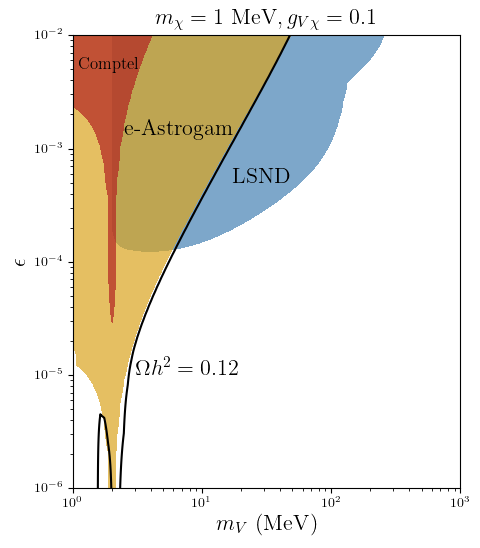

In [166]:
plt.figure(dpi=100,figsize=(5,6))
CS = plt.contourf(mvs,epss,numDMScatters,levels=[1e1,1e10], norm=LogNorm(),alpha=0.7,colors="steelblue")
plt.contour(mvs,epss,rds,levels=[0.12], colors="black")
plt.contourf(mvs, epss,sigma_vs-eastro_lims * 8.56656e16, levels=[0.0,np.inf],alpha=0.7,colors="goldenrod")
plt.contourf(mvs, epss,sigma_vs-comptel_lims * 8.56656e16, levels=[0.0,np.inf],alpha=0.7,colors="firebrick")
#plt.contourf(mvs, epss,sigma_vs-fermi_lims * 8.56656e16, levels=[0.0,np.inf],alpha=0.7)


plt.text(17, 5e-4, "LSND", fontsize=16)
plt.text(1.1, 5e-3, "Comptel", fontsize=12)
plt.text(2.5, 1.3e-3, "e-Astrogam", fontsize=16)
#plt.contour(MVS,KS,ADS,levels=[4.0*np.pi])
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\epsilon$', fontsize=16)
plt.xlabel(r'$m_V \ (\mathrm{MeV})$', fontsize=16);
plt.annotate(r"$\Omega h^2=0.12$",(3.0,1e-5),fontsize=16);
plt.title(r'$m_{\chi}=1\ \mathrm{MeV}, g_{V\chi}=0.1$',fontsize=16)
plt.savefig('figures/lsnd_gamma_ray_constraints.pdf')

#plt.clabel(CS, CS.levels, inline=True, fmt=r'%.0e',fontsize=10,)